In [2]:
import json
import glob
import datetime
from io import StringIO

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

In [2]:
# States are broken into networks. The networks have a list of ids, each representing a station.
# We will take that list of ids and pass them as query parameters to the URL we built up ealier.
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

In [3]:
# IEM has Iowa AWOS sites in its own labeled network
networks = ['AWOS'] + ['{}_ASOS'.format(state) for state in states]

In [35]:
def get_weather(stations, start=pd.Timestamp('2014-01-01'),
                end=pd.Timestamp('2014-01-31')):
    '''
    Fetch weather data from MESONet between ``start`` and ``stop``.
    '''
    url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
           "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
           "&tz=Etc/UTC&format=comma&latlon=no"
           "&{start:year1=%Y&month1=%m&day1=%d}"
           "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")
    stations = "&".join("station=%s" % s for s in stations)
    weather = (pd.read_csv(url.format(start=start, end=end, stations=stations),
                           comment="#")
                 .rename(columns={"valid": "date"})
                 .rename(columns=str.strip)
                 .assign(date=lambda df: pd.to_datetime(df['date']))
                 .set_index(["station", "date"])
                 .sort_index())
    float_cols = ['tmpf', 'relh', 'sped', 'mslp', 'p01i', 'vsby', "gust_mph"]
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors="coerce")
    return weather

In [31]:
def get_ids(network):
    url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
    r = requests.get(url.format(network))
    md = pd.json_normalize(r.json()['features'])
    md['network'] = network
    return md

In [9]:
url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
r = requests.get(url.format("AWOS"))
js = r.json()

In [22]:
js['features'][:2]

[{'type': 'Feature',
  'id': 'AXA',
  'properties': {'elevation': 368.8,
   'sname': 'ALGONA',
   'state': 'IA',
   'country': 'US',
   'climate_site': 'IA0133',
   'wfo': 'DMX',
   'tzname': 'America/Chicago',
   'ncdc81': 'USC00130133',
   'ugc_county': 'IAC109',
   'ugc_zone': 'IAZ005',
   'county': 'Kossuth',
   'sid': 'AXA'},
  'geometry': {'type': 'Point', 'coordinates': [-94.2724, 43.0796]}},
 {'type': 'Feature',
  'id': 'IKV',
  'properties': {'elevation': 270.7,
   'sname': 'ANKENY',
   'state': 'IA',
   'country': 'US',
   'climate_site': 'IA0241',
   'wfo': 'DMX',
   'tzname': 'America/Chicago',
   'ncdc81': 'USC00130241',
   'ugc_county': 'IAC153',
   'ugc_zone': 'IAZ060',
   'county': 'Polk',
   'sid': 'IKV'},
  'geometry': {'type': 'Point', 'coordinates': [-93.5695, 41.6878]}}]

In [25]:
pd.DataFrame(js['features']).head()

,type,id,properties,geometry
0,Feature,AXA,"{'elevation': 368.8, 'sname': 'ALGONA', 'state...","{'type': 'Point', 'coordinates': [-94.2724, 43..."
1,Feature,IKV,"{'elevation': 270.7, 'sname': 'ANKENY', 'state...","{'type': 'Point', 'coordinates': [-93.5695, 41..."
2,Feature,AIO,"{'elevation': 351.7, 'sname': 'ATLANTIC', 'sta...","{'type': 'Point', 'coordinates': [-95.0465, 41..."
3,Feature,ADU,"{'elevation': 399.3, 'sname': 'AUDUBON', 'stat...","{'type': 'Point', 'coordinates': [-94.9204, 41..."
4,Feature,BNW,"{'elevation': 349.3, 'sname': 'BOONE MUNI', 's...","{'type': 'Point', 'coordinates': [-93.8486, 42..."


In [26]:
js['features'][0]

{'type': 'Feature',
 'id': 'AXA',
 'properties': {'elevation': 368.8,
  'sname': 'ALGONA',
  'state': 'IA',
  'country': 'US',
  'climate_site': 'IA0133',
  'wfo': 'DMX',
  'tzname': 'America/Chicago',
  'ncdc81': 'USC00130133',
  'ugc_county': 'IAC109',
  'ugc_zone': 'IAZ005',
  'county': 'Kossuth',
  'sid': 'AXA'},
 'geometry': {'type': 'Point', 'coordinates': [-94.2724, 43.0796]}}

In [28]:
stations = pd.json_normalize(js['features']).id
url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
       "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
       "&tz=Etc/UTC&format=comma&latlon=no"
       "&{start:year1=%Y&month1=%m&day1=%d}"
       "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")
stations = "&".join("station=%s" % s for s in stations)
start = pd.Timestamp('2014-01-01')
end=pd.Timestamp('2014-01-31')

weather = (pd.read_csv(url.format(start=start, end=end, stations=stations),
                       comment="#"))

In [36]:
import os
ids = pd.concat([get_ids(network) for network in networks], ignore_index=True)
gr = ids.groupby('network')

os.makedirs("weather", exist_ok=True)

for i, (k, v) in enumerate(gr):
    print("{}/{}".format(i, len(networks)), end='\r')
    weather = get_weather(v['id'])
    weather.to_csv("weather/{}.csv".format(k))

In [25]:
weather = pd.concat([
    pd.read_csv(f, parse_dates=['date'], index_col=['station', 'date'])
    for f in glob.glob('weather/*.csv')])

weather.to_hdf('./data/weather.h5', key='weather', format='table')

In [44]:
weather = pd.read_hdf('./data/weather.h5')

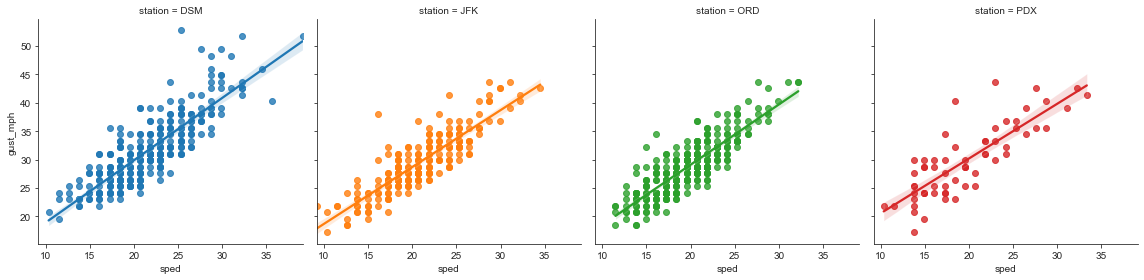

In [20]:
airports = ['DSM', 'ORD', 'JFK', 'PDX']

g = sns.FacetGrid(weather.sort_index().loc[airports].reset_index(),
                  col='station', hue='station', col_wrap=4, height=4)
g.map(sns.regplot, 'sped', 'gust_mph')

In [45]:
flights = pd.read_hdf('./data/flights.h5', 'flights')

In [22]:
weather_locs = weather.index.levels[0]
# The `categories` attribute of a Categorical is an Index
origin_locs = flights.origin.cat.categories
dest_locs = flights.dest.cat.categories

### Index = FrozenSet
All set operation could apply with index  

In [33]:
# find airport have index in weather, flights '&' as set intersection
airports = weather_locs & origin_locs & dest_locs

In [36]:
# '|' as set union, 'difference' as set diff
print("Weather, no flights:\n\t", weather_locs.difference(origin_locs | dest_locs), end='\n\n')

Weather, no flights:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', length=1910)



In [41]:
print("Flights, no weather:\n\t", (origin_locs | dest_locs).difference(weather_locs), end='\n\n')

Flights, no weather:
	 Index(['ADK', 'ADQ', 'ANC', 'BET', 'BQN', 'BRW', 'CDV', 'FAI', 'FCA', 'GUM',
       'HNL', 'ITO', 'JNU', 'KOA', 'KTN', 'LIH', 'MQT', 'OGG', 'OME', 'OTZ',
       'PPG', 'PSE', 'PSG', 'SCC', 'SCE', 'SIT', 'SJU', 'STT', 'STX', 'WRG',
       'YAK', 'YUM'],
      dtype='object')



In [42]:
print("Dropped Stations:\n\t", (origin_locs | dest_locs) ^ weather_locs)

Dropped Stations:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y63', 'Y70', 'YAK', 'YIP', 'YKM', 'YKN', 'YNG', 'YUM', 'ZPH', 'ZZV'],
      dtype='object', length=1942)


In [46]:
temp = weather['tmpf']

In [51]:
c = (temp - 32)/9*5

### Index is shared between , source and derivates
easy to align between same index

In [60]:
temp.index is c.index

True

In [61]:
c_f = pd.DataFrame({'c':c, 'f':temp})

In [63]:
c_f['c']/5 - (c_f['f']-32)/9

station  date               
BXK      2014-01-01 00:15:00   -4.440892e-16
         2014-01-01 00:35:00   -4.440892e-16
         2014-01-01 00:55:00    0.000000e+00
         2014-01-01 01:15:00    0.000000e+00
         2014-01-01 01:35:00    0.000000e+00
                                    ...     
ZPH      2014-01-30 22:35:00    0.000000e+00
         2014-01-30 22:55:00    0.000000e+00
         2014-01-30 23:15:00    0.000000e+00
         2014-01-30 23:35:00    0.000000e+00
         2014-01-30 23:55:00    0.000000e+00
Length: 3303647, dtype: float64

## All binary operations (add, multiply, etc...) between Series/DataFrames first align and then proceed.

In [79]:
dsm = weather.loc['DSM']
hourly = dsm.resample('H').mean()
temp = hourly['tmpf'].sample(frac=0.5, random_state=1).sort_index()
sped = hourly['sped'].sample(frac=0.5, random_state=2).sort_index()

In [80]:
temp.head()

date
2014-01-01 00:00:00    10.94
2014-01-01 02:00:00    10.94
2014-01-01 03:00:00    10.94
2014-01-01 04:00:00    10.04
2014-01-01 05:00:00    10.04
Name: tmpf, dtype: float64

In [81]:
sped.head()

date
2014-01-01 01:00:00    11.50
2014-01-01 02:00:00     8.05
2014-01-01 03:00:00     9.20
2014-01-01 04:00:00     9.20
2014-01-01 05:00:00    10.35
Name: sped, dtype: float64

In [84]:
sped/temp

date
2014-01-01 00:00:00         NaN
2014-01-01 01:00:00         NaN
2014-01-01 02:00:00    0.735832
2014-01-01 03:00:00    0.840951
2014-01-01 04:00:00    0.916335
                         ...   
2014-01-30 13:00:00         NaN
2014-01-30 14:00:00    0.590416
2014-01-30 17:00:00         NaN
2014-01-30 21:00:00         NaN
2014-01-30 23:00:00         NaN
Length: 550, dtype: float64

In [83]:
# Auto alignment of index
sped.div(temp, fill_value=1)

date
2014-01-01 00:00:00     0.091408
2014-01-01 01:00:00    11.500000
2014-01-01 02:00:00     0.735832
2014-01-01 03:00:00     0.840951
2014-01-01 04:00:00     0.916335
                         ...    
2014-01-30 13:00:00     0.027809
2014-01-30 14:00:00     0.590416
2014-01-30 17:00:00     0.023267
2014-01-30 21:00:00     0.035663
2014-01-30 23:00:00    13.800000
Length: 550, dtype: float64

In [87]:
hourly.div(sped, axis='index')

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,0.951304,6.329565,1.0,89.165217,0.0,0.869565,NaN
2014-01-01 02:00:00,1.359006,9.042236,1.0,127.366460,0.0,1.242236,NaN
2014-01-01 03:00:00,1.189130,7.911957,1.0,111.445652,0.0,1.086957,NaN
2014-01-01 04:00:00,1.091304,7.901087,1.0,111.380435,0.0,1.086957,NaN
...,...,...,...,...,...,...,...
2014-01-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merging
Relational `pd.merge`  
Array `pd.concat`

In [94]:
# Concat axis = column -> convert Series -> DF
pd.concat([temp, sped], axis=0).head()

date
2014-01-01 00:00:00    10.94
2014-01-01 02:00:00    10.94
2014-01-01 03:00:00    10.94
2014-01-01 04:00:00    10.04
2014-01-01 05:00:00    10.04
dtype: float64

In [96]:
# use join = 'inner', for common index
pd.concat([temp, sped], axis=1, join='inner').head()

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.05
2014-01-01 03:00:00,10.94,9.20
2014-01-01 04:00:00,10.04,9.20
2014-01-01 05:00:00,10.04,10.35
2014-01-01 13:00:00,8.96,13.80


In [103]:
pd.merge(temp, sped, left_index=True, right_index=True, how = 'right')

,tmpf,sped
date,,
2014-01-01 01:00:00,NaN,11.50
2014-01-01 02:00:00,10.94,8.05
2014-01-01 03:00:00,10.94,9.20
2014-01-01 04:00:00,10.04,9.20
2014-01-01 05:00:00,10.04,10.35
...,...,...
2014-01-30 06:00:00,NaN,14.95
2014-01-30 09:00:00,35.06,16.10
2014-01-30 10:00:00,35.06,21.85


In [106]:
idx_cols = ['unique_carrier', 'origin', 'dest', 'tail_num', 'fl_num', 'fl_date']
data_cols = ['crs_dep_time', 'dep_delay', 'crs_arr_time', 'arr_delay',
             'taxi_out', 'taxi_in', 'wheels_off', 'wheels_on']

df = flights.set_index(idx_cols)[data_cols].sort_index()

In [107]:
df.head()

crs_dep_time  \
unique_carrier origin dest tail_num fl_num fl_date                          
AA             ABQ    DFW  N3ABAA   1282   2017-01-29 2017-01-29 08:00:00   
                                    2611   2017-01-15 2017-01-15 05:00:00   
                           N3AEAA   2511   2017-01-11 2017-01-11 15:00:00   
                           N3AJAA   2511   2017-01-24 2017-01-24 15:00:00   
                           N3AVAA   1282   2017-01-11 2017-01-11 08:00:00   

                                                       dep_delay  \
unique_carrier origin dest tail_num fl_num fl_date                 
AA             ABQ    DFW  N3ABAA   1282   2017-01-29       -3.0   
                                    2611   2017-01-15        0.0   
                           N3AEAA   2511   2017-01-11       -9.0   
                           N3AJAA   2511   2017-01-24        2.0   
                           N3AVAA   1282   2017-01-11       -8.0   

                                                             crs_arr_time  \
unique_carrier origin dest tail_num fl_num fl_date                          
AA             ABQ    DFW  N3ABAA   1282   2017-01-29 2017-01-29 10:50:00   
                                    2611   2017-01-15 2017-01-15 07:46:00   
                           N3AEAA   2511   2017-01-11 2017-01-11 17:45:00   
                           N3AJAA   2511   2017-01-24 2017-01-24 17:45:00   
                           N3AVAA   1282   2017-01-11 2017-01-11 10:50:00   

                                                       arr_delay  taxi_out  \
unique_carrier origin dest tail_num fl_num fl_date                           
AA             ABQ    DFW  N3ABAA   1282   2017-01-29      -11.0      13.0   
                                    2611   2017-01-15        0.0      12.0   
                           N3AEAA   2511   2017-01-11       19.0      23.0   
                           N3AJAA   2511   2017-01-24       -8.0      13.0   
                           N3AVAA   1282   2017-01-11       -3.0      10.0   

                                                       taxi_in  wheels_off  \
unique_carrier origin dest tail_num fl_num fl_date                           
AA             ABQ    DFW  N3ABAA   1282   2017-01-29     10.0       810.0   
                                    2611   2017-01-15      9.0       512.0   
                           N3AEAA   2511   2017-01-11     35.0      1514.0   
                           N3AJAA   2511   2017-01-24     10.0      1515.0   
                           N3AVAA   1282   2017-01-11     34.0       802.0   

                                                       wheels_on  
unique_carrier origin dest tail_num fl_num fl_date                
AA             ABQ    DFW  N3ABAA   1282   2017-01-29     1029.0  
                                    2611   2017-01-15      737.0  
                           N3AEAA   2511   2017-01-11     1729.0  
                           N3AJAA   2511   2017-01-24     1727.0  
                           N3AVAA   1282   2017-01-11     1013.0

In [112]:
def mode(x):
    '''
    Arbitrarily break ties.
    '''
    return x.value_counts().index[0]

aggfuncs = {'tmpf': 'mean', 'relh': 'mean',
            'sped': 'mean', 'mslp': 'mean',
            'p01i': 'mean', 'vsby': 'mean',
            'gust_mph': 'mean', 'skyc1': mode,
            'skyc2': mode, 'skyc3': mode}

In [113]:
# TimeGrouper works on a DatetimeIndex, so we move `station` to the
# columns and then groupby it as well.
daily = (weather.reset_index(level="station")
                .groupby([pd.Grouper(freq='D'), "station"])
                .agg(aggfuncs))

In [118]:
daily

tmpf        relh       sped         mslp      p01i  \
date       station                                                            
2014-01-01 01M      35.747500   81.117917   2.284028          NaN  0.000000   
           04V      18.350000   72.697778  11.228472          NaN  0.000000   
           04W      -9.075000   69.908056   3.625694          NaN  0.000000   
           05U      26.321127   71.519859   3.806338          NaN  0.000000   
           06D     -11.388060   73.784179   5.334722          NaN  0.000000   
...                       ...         ...        ...          ...       ...   
2014-01-30 YKM      32.480000   89.307917   3.282292  1009.391667  0.000004   
           YKN      30.326761   53.978310  17.444366          NaN  0.000704   
           YNG      14.262500   48.225417  10.493750  1023.762500  0.000000   
           ZPH      42.625000  100.000000   8.097917          NaN  0.007917   
           ZZV      11.817500   53.519167   5.558333  1024.983333  0.000000   

                         vsby   gust_mph skyc1 skyc2 skyc3  
date       station                                          
2014-01-01 01M       9.229167        NaN   CLR     M     M  
           04V       9.861111  31.583929   CLR     M     M  
           04W      10.000000        NaN   OVC     M     M  
           05U       9.929577        NaN   CLR     M     M  
           06D       9.576389        NaN   CLR     M     M  
...                       ...        ...   ...   ...   ...  
2014-01-30 YKM       3.166667        NaN   VV      M     M  
           YKN       9.901408  28.160976   CLR     M     M  
           YNG      10.000000  20.412500   CLR     M     M  
           ZPH       8.569444  16.100000   OVC     M     M  
           ZZV       9.916667        NaN   CLR     M     M  

[64348 rows x 10 columns]

In [172]:
m = pd.merge(flights, 
         daily.rename_axis(index={'date':'fl_date', 'station':'origin'})
         .reset_index()
         .assign(fl_date=lambda x : x['fl_date'] + pd.offsets.DateOffset(years=3)), # add 3 years to daily to match year with flights
         on=['fl_date', 'origin']).set_index(idx_cols).sort_index()

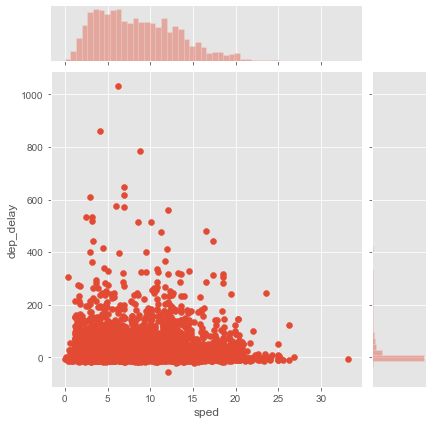

In [174]:
plt.style.use('ggplot')
m.sample(n=10000).pipe((sns.jointplot, 'data'), 'sped', 'dep_delay')

In [175]:
import statsmodels.api as sm

In [177]:
mod = sm.OLS.from_formula('dep_delay ~ C(skyc1) + tmpf + relh + sped + mslp', data=m)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dep_delay   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     85.55
Date:                Tue, 28 Jul 2020   Prob (F-statistic):          3.68e-177
Time:                        17:50:39   Log-Likelihood:            -2.1649e+06
No. Observations:              410537   AIC:                         4.330e+06
Df Residuals:                  410526   BIC:                         4.330e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -219.2746     11.235    -19.517      0.000    -241.295    -197.254
C(skyc1)[T.CLR]     0.5706      0.259      2.206      0.027       0.064       1.078
C(skyc1)[T.FEW]     1.8005      0.231      7.809      0.000       1.349       2.252
C(skyc1)[T.M]       9.9807      9.259      1.078      0.281      -8.167      28.128
C(skyc1)[T.OVC]    -0.2377      0.283     -0.840      0.401      -0.793       0.317
C(skyc1)[T.SCT]     3.3001      0.405      8.158      0.000       2.507       4.093
C(skyc1)[T.VV ]    -0.7208      0.480     -1.502      0.133      -1.662       0.220
tmpf               -0.0344      0.005     -6.951      0.000      -0.044      -0.025
relh                0.0370      0.004      8.324      0.000       0.028       0.046
sped                0.1064      0.019      5.592      0.000       0.069       0.144
mslp                0.2248      0.011     20.716      0.000       0.204       0.246
==============================================================================
Omnibus:                   611644.075   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        493466998.129
Skew:                           8.962   Prob(JB):                         0.00
Kurtosis:                     171.899   Cond. No.                     1.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

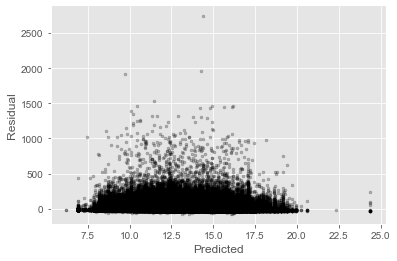

In [181]:
fig, ax = plt.subplots()
ax.scatter(res.fittedvalues, res.resid, color='k', marker='.', alpha=0.25)
ax.set(xlabel='Predicted', ylabel='Residual')
sns.despine()